## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [ ]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "./data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


(1000, 1536)

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


Cluster
1    4.037175
3    4.191176
0    4.215613
2    4.377301
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

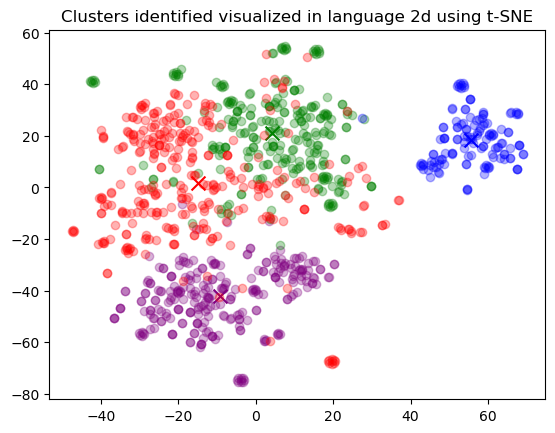

In [ ]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use text-davinci-003 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [ ]:
import openai

#API Key
#Store you key in a file and read it
f = open("api_key.txt", "r")
API_KEY=f.readline()
f.close()

#The OpenAI Key
import os
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

In [ ]:
# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  All of the reviews are positive and express satisfaction with the product.
5, Fog Chaser Coffee:   This coffee has a full body and a rich taste. The price is far below t
5, Excellent taste:   This is to me a great coffee, once you try it you will enjoy it, this 
4, Good, but not Wolfgang Puck good:   Honestly, I have to admit that I expected a little better. That's not 
5, Just My Kind of Coffee:   Coffee Masters Hazelnut coffee used to be carried in a local coffee/pa
5, Rodeo Drive is Crazy Good Coffee!:   Rodeo Drive is my absolute favorite and I'm ready to order more!  That
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  All of the reviews are positive and express satisfaction with the product.
5, Makes me drool just thinking of them:   The Brit's have out done us. The flavor is supreme,they satisfy my hun
5, My favorite:   These are one of my favorite snacks.  I realize I may not be among the
5

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.